### Brain extraction(Skull stripping)

**Learning outcomes:**
- How to do quick brain extraction using ants(antspynet module)

In [1]:
%matplotlib inline

import os
from helpers import *

import ants
# noinspection PyPep8Naming
import SimpleITK as sitk

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.4
SimpleITK version = 2.4.1


In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print(f'project folder = {BASE_DIR}')

project folder = /home/younes/PycharmProjects/MRI-preprocessing-techniques


In [3]:
raw_examples = [
    'fsl-open-dev_sub-001_T1w.nii.gz',
    'wash-120_sub-001_T1w.nii.gz',
    'kf-panda_sub-01_ses-3T_T1w.nii.gz',
    'listen-task_sub-UTS01_ses-1_T1w.nii.gz',
    'brain-lesion_T1w.nii.gz'
]

#### Raw Image

shape = (192, 192, 160) -> (Z, X, Y)


interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

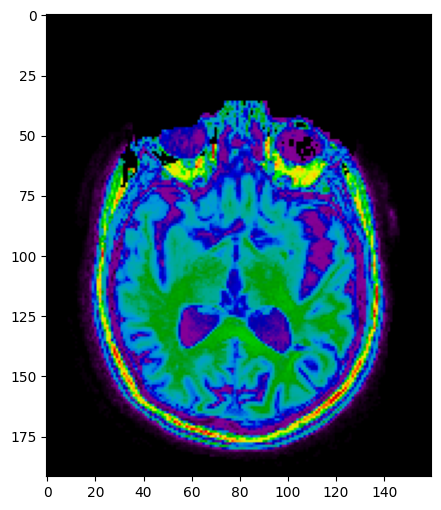

In [4]:
raw_example = raw_examples[4]
raw_img_path = os.path.join(BASE_DIR, 'assets', 'raw_examples', raw_example)
raw_img_ants = ants.image_read(raw_img_path, reorient='IAL')

print(f'shape = {raw_img_ants.numpy().shape} -> (Z, X, Y)')

explore_3D_array(arr=raw_img_ants.numpy(), cmap='nipy_spectral')

#### Deep Learning based method

#### Load Model via AntsPyNet API and predict

In [5]:
from antspynet.utilities import brain_extraction

2025-01-28 13:06:16.709312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 13:06:16.722157: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 13:06:16.746892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 13:06:16.783806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 13:06:16.807149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 13:06:16.843694: I tensorflow/core/platform/cpu_feature_gu

In [7]:
prob_brain_mask = brain_extraction(raw_img_ants,modality="t1",verbose=True)

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Brain extraction:  renormalize probability mask to native space.


#### Inspect probabilities array

ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (192, 192, 160)
	 Spacing    : (1.25, 1.25, 1.2)
	 Origin     : (98.1114, -149.1525, -129.5975)
	 Direction  : [-0.  0. -1.  0.  1.  0.  1.  0.  0.]



interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

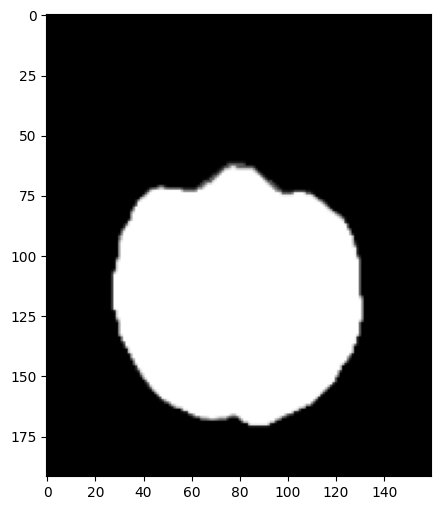

In [8]:
print(prob_brain_mask)
explore_3D_array(prob_brain_mask.numpy())

#### Generate final mask

In [9]:
brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)

interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

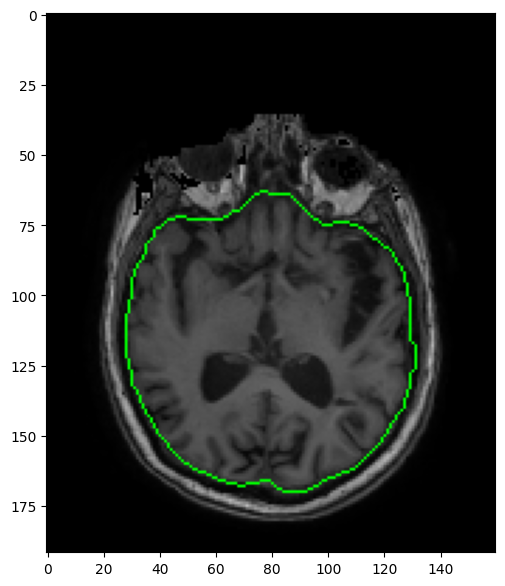

In [11]:
explore_3D_array_with_mask_contour(raw_img_ants.numpy(), brain_mask.numpy())

In [13]:
out_folder =  os.path.join(BASE_DIR, 'assets', 'preprocessed')
out_folder = os.path.join(out_folder, raw_example.split('.')[0]) # create folder with name of the raw file
os.makedirs(out_folder, exist_ok=True) # create folder if not exists

out_filename = add_suffix_to_filename(raw_example, suffix='brainMaskByDL')
out_path = os.path.join(out_folder, out_filename)

print(raw_img_path[len(BASE_DIR):])
print(out_path[len(BASE_DIR):])

/assets/raw_examples/brain-lesion_T1w.nii.gz
/assets/preprocessed/brain-lesion_T1w/brain-lesion_T1w_brainMaskByDL.nii.gz


In [14]:
brain_mask.to_file(out_path)

#### Generate brain masked

interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

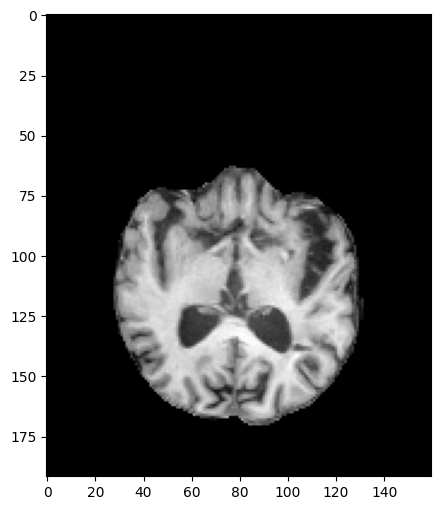

In [15]:
masked = ants.mask_image(raw_img_ants, brain_mask)

explore_3D_array(masked.numpy())

In [16]:
out_filename = add_suffix_to_filename(raw_example, suffix='brainMaskedByDL')
out_path = os.path.join(out_folder, out_filename)

print(raw_img_path[len(BASE_DIR):])
print(out_path[len(BASE_DIR):])

/assets/raw_examples/brain-lesion_T1w.nii.gz
/assets/preprocessed/brain-lesion_T1w/brain-lesion_T1w_brainMaskedByDL.nii.gz


In [17]:
masked.to_file(out_path)